In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 目的

下記のことを確かめる。
- 誤差逆伝播によるパラメータ更新で、実際に２乗誤差を減らすことができる。
- 数値微分を用いることで、誤差逆伝播による微分値をテストできる。

これに付随して、どの様にコーディングすると開発しやすいかについても解説する。 <- こちらがメインになるかも

# やること
誤差逆伝播法によって sin カーブにフィットできるような、ニューラルネットワークを開発する。

# 前提
学習タスクの設定は下記の通り
- １変数特徴量の回帰問題
- ニューラルネットワークモデルは隠れ１層、活性化関数は tanh() を使用（p231 図5.3と同一）
- ユニット数は、入力、隠れ、出力の順に [2,3,1] （p231 図5.3と同一）

# 手順
システム開発のフレームワークの一つである、テスト駆動開発（TDD)に従って開発する。（今回は、ちょうどテストの話がでてくるので題材としてちょうどよかった）
テスト駆動開発では、システムの要件を満たすようなテストを実装することから開始する。
テストを実装し終えたら、そのテストが通るようなシステムを開発し始め、「テストが通る＝要件を満たすシステムである」という状態をゴールとする開発スタイルである。

TDDのメリットはいくつかあるが、何から実装し始めればよいかがひと目でわかる点だと思っている。
今回でいうと、「誤差逆伝播法により誤差の微分を算出できるシステムを作れ」と言われたときに、たいていの人は何から実装を始めればよいか途方に暮れる（クラスを書く？メンバ変数を書く？順伝搬メソッドを書く？など）。必要だと思われる機能からボトムアップ的にコーディングしていくと、不必要な機能を開発してしまうことも生じる。

TDDでは、テストメソッドを先に書くことによって、システムの出力から書き下せるので、トップダウンにシステムを構築することができ、必要な機能だけに集中して開発を開始することができる。

## 具体的には
今回では、数値微分によって誤差逆伝播をテストできるということを仮定して、誤差逆伝播による誤差の微分が正しいかのテストを書く。このテストをパスするようなクラスを書くことができれば、システムの開発完了となる。

In [8]:
def test_back_prop(model):
  # 誤差逆伝播による微分と数値微分がだいたい等しくなることをテストする。
  test_x_list = [-2, -1, 0, 1, 2] # テスト用のデータ
  test_t_list = [3, 1, 9, 10000, 0]
  for x, t in zip(test_x_list, test_t_list):
    # 誤差逆伝播の結果、誤差の微分を出力する機能がほしい
    diff_err_list = model.back_prop(x, t)
    # 数値微分を出力する機能もほしい
    diff_err_num_list = model.numeric_diff(x, t)
    for diff_err, diff_err_numeric in zip(diff_err_list, diff_err_num_list): # 層ごとに微分値が出るので、層で for 文を回す
      # 今回は簡単のため、微分値の符号が一致することのみチェックする。
      is_sign_match = np.equal((diff_err <0),(diff_err_numeric <0)).all()
      message = 'Derivative value does not match : \n{} \nand \n {}.'.format(diff_err, diff_err_numeric)
      print(message)
      assert is_sign_match, message # 符号が一つでも一致しなかったらエラーを吐く
  print('test passed!')

テストケースを書くことができたら、 model が属するクラスに２つのメソッドが必要であることがわかる。
- back_prop : 逆伝播によって誤差の微分を算出するメソッド
- numeric_diff　：　数値微分によって誤差の微分を算出するメソッド

次にやるべきことは、クラスを書いてこの２つのメソッドをコーディングすることだとわかる。

In [5]:
class FF_model():
  def back_prop(self, x, t):
    pass

  def numeric_diff(self, x, t):
    # ここから実装を始める。
    pass

だいたい一個のメソッドを書いていると、使いまわしたい機能とか、分離したい機能とかがでてくるので、そのタイミングで、その機能の要件を満たすテストを記述する。テストができたらそのテストをパスするようなメソッドを実装する。

今回の例だと、 forward は使いまわせそうな機能だったため、別メソッドに分離した。
完成形は次の通り

In [6]:
class FF_model():
  def __init__(self, in_dim=2, hidden_dim=3, out_dim=1):
    self.w_1 = np.random.normal(size=(in_dim, hidden_dim))
    self.w_2 = np.random.normal(size=(hidden_dim,out_dim))
    self.in_dim = in_dim
    self.hidden_dim = hidden_dim
    self.out_dim = out_dim

  def forward(self, x, w_1=None, w_2=None):
    _w_1 = self.w_1 if w_1 is None else w_1
    _w_2 = self.w_2 if w_2 is None else w_2

    input_layer = np.array([[x, 1]])
    hidden_layer = np.matmul(input_layer, _w_1)
    hidden_activation = np.tanh(hidden_layer)
    out_layer = np.matmul(hidden_activation, _w_2)
    # 1x1 行列をスカラ値に治す
    out = np.squeeze(out_layer)
    self.prev_unit_outs = [input_layer, hidden_layer, hidden_activation, out_layer]
    return out


  def back_prop(self, x, t):
    # 一度 forward して、各ユニットの出力を取得する。
    self.forward(x)
    input_layer, hidden_layer, hidden_activation, out_layer = self.prev_unit_outs
    # 出力ユニットの誤差
    out_layer_delta = (self.forward(x) - t).reshape([1, self.out_dim])
    out_layer_diff = np.matmul(hidden_activation.transpose(), out_layer_delta)
    # 隠れユニットの誤差
    h_dashed = 1 - np.tanh(hidden_layer)**2
    hidden_layer_delta = h_dashed * np.matmul(out_layer_delta, self.w_2.transpose())
    hidden_layer_diff = np.matmul(input_layer.transpose(), hidden_layer_delta)
    return [hidden_layer_diff, out_layer_diff]

  def numeric_diff(self, x, t):
    # 教科書で言う E_n(w_i,j)  を３shつ
    error = (self.forward(x) - t)**2 / 2 # ここで foward メソッド欲しいな、と思ったら、既にある体で使う。 foward は後で実装する。
    epsilon = 10**(-3)

    # １層目の数値微分を求める。 空の行列を作り、 for 文で一個ずつ結果を埋めていく。
    error_diff_numeric_1 = np.zeros_like(self.w_1)
    dim_1_1, dim_1_2 = error_diff_numeric_1.shape
    for i in range(dim_1_1):
      for j in range(dim_1_2):
        # w_i,j に適用する摂動を作成
        pertubation = np.zeros_like(self.w_1)
        pertubation[i, j] = epsilon
        alt_w_1 = self.w_1 + pertubation
        error_pert = (self.forward(x, w_1=alt_w_1) - t)**2 / 2
        # (5.68 式)で w_i,j による誤差の数値微分を算出
        diff_err_num_i_j = (error_pert - error) / epsilon
        error_diff_numeric_1[i,j] = diff_err_num_i_j

    # 2層目の数値微分を求める。 空の行列を作り、 for 文で要素を埋めていく。
    error_diff_numeric_2 = np.zeros_like(self.w_2)
    dim_2_1, dim_2_2 = error_diff_numeric_2.shape
    for i in range(dim_2_1):
      for j in range(dim_2_2):
        # w_i,j に適用する摂動を作成
        pertubation = np.zeros_like(self.w_2)
        pertubation[i, j] = epsilon
        alt_w_2 = self.w_2 + pertubation
        error_pert = (self.forward(x, w_2=alt_w_2) - t)**2 / 2
        # (5.68 式)で w_i,j による誤差の数値微分を算出
        diff_err_num_i_j = (error_pert - error) / epsilon
        error_diff_numeric_2[i,j] = diff_err_num_i_j
    return [error_diff_numeric_1, error_diff_numeric_2]

  def fit_once(self, x, t, lerning_rate=0.01):
    hidden_derivative, out_derivative = self.back_prop(x, t)
    self.w_1 = self.w_1 - lerning_rate * hidden_derivative
    self.w_2 = self.w_2 - lerning_rate * out_derivative
    loss = (float(self.forward(x)) - t)**2 / 2
    return loss

In [9]:
model = FF_model()
test_back_prop(model)

Derivative value does not match : 
[[ 2.24537777  3.97741173  0.02136452]
 [-1.12268888 -1.98870586 -0.01068226]] 
and 
 [[ 2.24225931  3.98114107  0.02132217]
 [-1.12346899 -1.98777281 -0.01069286]].
Derivative value does not match : 
[[ 2.57871906]
 [-1.34642714]
 [ 3.45431326]] 
and 
 [[ 2.57899365]
 [-1.34635228]
 [ 3.45480599]].
Derivative value does not match : 
[[ 1.07145662  0.98399738  0.02222928]
 [-1.07145662 -0.98399738 -0.02222928]] 
and 
 [[ 1.07132304  0.98382973  0.02220787]
 [-1.07158945 -0.98416437 -0.02225072]].
Derivative value does not match : 
[[0.52875558]
 [0.57861506]
 [1.61149473]] 
and 
 [[0.528806  ]
 [0.57867544]
 [1.61196309]].
Derivative value does not match : 
[[ 0.          0.          0.        ]
 [-6.25515449 -2.17860467 -0.50879439]] 
and 
 [[ 0.          0.          0.        ]
 [-6.25314389 -2.18034859 -0.50923284]].
Derivative value does not match : 
[[-2.73035682]
 [ 7.73442416]
 [ 8.22932539]] 
and 
 [[-2.73031572]
 [ 7.73475398]
 [ 8.22969877]]

## 実際に学習を適用する

f(x) = sin(x) から生成する学習データサンプルを50個生成する。

In [10]:
x = np.linspace(-2.5, 2.5, num=50)
t = np.sin(x)

train_df = pd.DataFrame({
    'x': x,
    't': t
})

学習前の予測を見てみる。

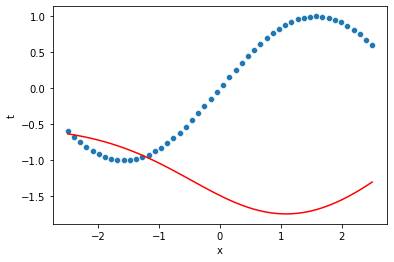

In [19]:
model = FF_model()
pre_pred = [float(model.forward(x)) for x in train_df['x']]

sns.scatterplot(x='x', y='t', data=train_df)
sns.lineplot(x=train_df['x'], y=pre_pred, color='r')

*学習を* 1000 サイクル実行する

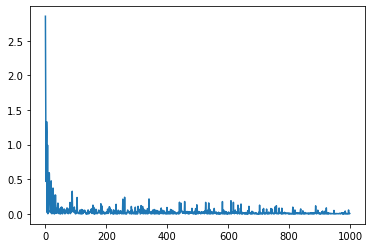

In [20]:
N = 1000

losses = []
for i in range(N):
  # データを無作為復元抽出する
  x, t = train_df.sample(1).reset_index().loc[0,['x','t']]
  losses.append(model.fit_once(x,t))

sns.lineplot(x=range(len(losses)), y=losses)

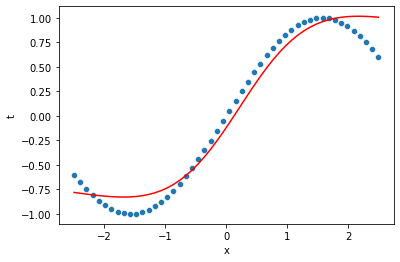

In [21]:
pred = [float(model.forward(x)) for x in train_df['x']]

sns.scatterplot(x='x', y='t', data=train_df)
sns.lineplot(x=train_df['x'], y=pred, color='r')